In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 500
batch_size = 128
F_MAP_1 = 95
F_MAP_2 = 100


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
with open('data_batch_1', 'rb') as db:
    try:
        train_samples = pickle.load(db)
    except UnicodeDecodeError:  #python 3.x
        db.seek(0)
        train_samples = pickle.load(db, encoding='latin1')

trainX, trainY = train_samples['data'], train_samples['labels']

trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.int32)
    
trainY_ = np.zeros([trainY.shape[0], NUM_CLASSES])
trainY_[np.arange(trainY.shape[0]), trainY-1] = 1

print(trainX.shape, trainY_.shape)



(10000, 3072) (10000, 10)


In [4]:
with open('test_batch_trim', 'rb') as tb:
    try:
        test_samples = pickle.load(tb)
    except UnicodeDecodeError:  #python 3.x
        tb.seek(0)
        test_samples = pickle.load(tb, encoding='latin1')
        
testX, testY = test_samples['data'], test_samples['labels']

testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.int32)
    
testY_ = np.zeros([testY.shape[0], NUM_CLASSES])
testY_[np.arange(testY.shape[0]), testY-1] = 1

print(testX.shape, testY_.shape)

(2000, 3072) (2000, 10)


In [5]:
trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

 # Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

images = x
images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
#Conv 1 -- maps one RGB image (3x32x32) to 50 feature maps (50x24x24), pool to (50x12x12)
W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, F_MAP_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
b1 = tf.Variable(tf.zeros([F_MAP_1]), name='biases_1')

conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

#Conv 2 -- maps 50 feature maps (50x12x12) to 60 (60x8x8), pool to (60x4x4)
W2 = tf.Variable(tf.truncated_normal([5, 5, F_MAP_1, F_MAP_2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
b2 = tf.Variable(tf.zeros([F_MAP_2]), name='biases_2')

conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1,1,1,1,], padding='VALID')+ b2)
pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

#Fully Connected Layer -- maps 60 feature maps (60x4x4) to 300 features
pool_2_shape = pool_2.get_shape().as_list()
dim = pool_2_shape[1] * pool_2_shape[2] * pool_2_shape[3]
reshape = tf.reshape(pool_2, [-1, dim])

W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
b3 = tf.Variable(tf.zeros([300]), name='biases_3')

fcon = tf.nn.relu(tf.matmul(reshape, W3) + b3)

#Softmax
W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
logits = tf.matmul(fcon, W4) + b4

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Using Adam Optimizer algorithm
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
print(N)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    training_loss = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY_ = trainX[idx], trainY_[idx]
        
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start:end], y_: trainY_[start:end]})
            
        training_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY_}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY_}))

        print('epoch', e, 'entropy', training_loss[e], 'test accuracy', test_acc[e])
    

10000
epoch 0 entropy 1.78255 test accuracy 0.3565
epoch 1 entropy 1.6922188 test accuracy 0.3565
epoch 2 entropy 1.513557 test accuracy 0.412
epoch 3 entropy 1.45039 test accuracy 0.445
epoch 4 entropy 1.3527919 test accuracy 0.4445
epoch 5 entropy 1.3259531 test accuracy 0.419
epoch 6 entropy 1.2817701 test accuracy 0.4025
epoch 7 entropy 1.2072779 test accuracy 0.4515
epoch 8 entropy 1.1456923 test accuracy 0.442
epoch 9 entropy 1.0683006 test accuracy 0.4555
epoch 10 entropy 1.0367099 test accuracy 0.3925
epoch 11 entropy 0.92747635 test accuracy 0.3835
epoch 12 entropy 0.82848144 test accuracy 0.429
epoch 13 entropy 0.7346598 test accuracy 0.423
epoch 14 entropy 0.71301615 test accuracy 0.452
epoch 15 entropy 0.6413756 test accuracy 0.38
epoch 16 entropy 0.5613244 test accuracy 0.4475
epoch 17 entropy 0.48051983 test accuracy 0.4085
epoch 18 entropy 0.3725274 test accuracy 0.43
epoch 19 entropy 0.42722413 test accuracy 0.364
epoch 20 entropy 0.30001664 test accuracy 0.4425
epoch 2

epoch 162 entropy 5.5910136e-06 test accuracy 0.433
epoch 163 entropy 5.205884e-06 test accuracy 0.4375
epoch 164 entropy 5.0932354e-06 test accuracy 0.437
epoch 165 entropy 4.850181e-06 test accuracy 0.4335
epoch 166 entropy 4.700055e-06 test accuracy 0.4335
epoch 167 entropy 4.4629505e-06 test accuracy 0.439
epoch 168 entropy 4.208763e-06 test accuracy 0.4365
epoch 169 entropy 4.098821e-06 test accuracy 0.432
epoch 170 entropy 3.912761e-06 test accuracy 0.4335
epoch 171 entropy 3.6794625e-06 test accuracy 0.4305
epoch 172 entropy 3.4983516e-06 test accuracy 0.4335
epoch 173 entropy 3.3396743e-06 test accuracy 0.435
epoch 174 entropy 3.2112002e-06 test accuracy 0.435
epoch 175 entropy 3.0728277e-06 test accuracy 0.434
epoch 176 entropy 2.9541793e-06 test accuracy 0.437
epoch 177 entropy 2.7843325e-06 test accuracy 0.4335
epoch 178 entropy 2.6780351e-06 test accuracy 0.433
epoch 179 entropy 2.6496873e-06 test accuracy 0.4335
epoch 180 entropy 2.5277702e-06 test accuracy 0.433
epoch 181

epoch 322 entropy 1.2761874 test accuracy 0.3075
epoch 323 entropy 1.2206581 test accuracy 0.297
epoch 324 entropy 1.211726 test accuracy 0.311
epoch 325 entropy 1.2021918 test accuracy 0.267
epoch 326 entropy 1.2071931 test accuracy 0.299
epoch 327 entropy 1.1386286 test accuracy 0.298
epoch 328 entropy 1.1341755 test accuracy 0.3265
epoch 329 entropy 1.1134698 test accuracy 0.2995
epoch 330 entropy 1.085954 test accuracy 0.3215
epoch 331 entropy 1.0677582 test accuracy 0.308
epoch 332 entropy 1.0638031 test accuracy 0.2835
epoch 333 entropy 1.0397781 test accuracy 0.2965
epoch 334 entropy 1.0356364 test accuracy 0.296
epoch 335 entropy 1.0109144 test accuracy 0.313
epoch 336 entropy 0.9990692 test accuracy 0.2985
epoch 337 entropy 1.049679 test accuracy 0.3365
epoch 338 entropy 0.94866914 test accuracy 0.3065
epoch 339 entropy 0.94372576 test accuracy 0.321
epoch 340 entropy 0.9462822 test accuracy 0.2945
epoch 341 entropy 0.93135107 test accuracy 0.3055
epoch 342 entropy 0.8785381 t

epoch 489 entropy 0.05564302 test accuracy 0.3365
epoch 490 entropy 0.045832984 test accuracy 0.339
epoch 491 entropy 0.03725227 test accuracy 0.3365
epoch 492 entropy 0.03479867 test accuracy 0.3385
epoch 493 entropy 0.03004328 test accuracy 0.337
epoch 494 entropy 0.03076834 test accuracy 0.3365
epoch 495 entropy 0.02916861 test accuracy 0.336
epoch 496 entropy 0.026276238 test accuracy 0.333
epoch 497 entropy 0.025613757 test accuracy 0.3375
epoch 498 entropy 0.025178134 test accuracy 0.3315
epoch 499 entropy 0.024787223 test accuracy 0.33


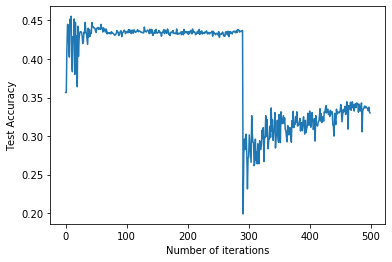

In [6]:
    plt.figure(1)
    plt.plot(range(epochs), test_acc)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Number of iterations')
    plt.savefig('./A3c-Test_accuracy.png')

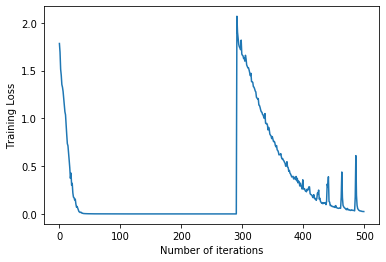

In [7]:
    plt.figure(2)
    plt.plot(range(epochs), training_loss)
    plt.xlabel('Number of iterations')
    plt.ylabel('Training Loss')
    plt.savefig('./A3c-Training_loss.png')